In [1]:
# Import libraries and load data
import glob
import json
import logging
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import warnings
import os
from matplotlib.patches import FancyBboxPatch
from datetime import datetime

# Configure
logging.getLogger('matplotlib.font_manager').disabled = True
warnings.filterwarnings("ignore")

# Load data
data_path = '../data/nvd.jsonl'
if not os.path.exists(data_path):
    raise FileNotFoundError(f"Data file not found at {data_path}")

def get_nested_value(entry, keys, default='Missing_Data'):
    try:
        for key in keys:
            entry = entry[key]
        return entry
    except (KeyError, IndexError):
        return default

row_accumulator = []
with open(data_path, 'r', encoding='utf-8') as f:
    nvd_data = json.load(f)
    for entry in nvd_data:
        new_row = {
            'CVE': get_nested_value(entry, ['cve', 'id']),
            'Published': get_nested_value(entry, ['cve', 'published']),
            'BaseScore': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'baseScore'], '0.0'),
            'Status': get_nested_value(entry, ['cve', 'vulnStatus'], '')
        }
        row_accumulator.append(new_row)

nvd = pd.DataFrame(row_accumulator)
nvd = nvd[~nvd.Status.str.contains('Rejected')]
nvd['Published'] = pd.to_datetime(nvd['Published'])
nvd['BaseScore'] = pd.to_numeric(nvd['BaseScore'], errors='coerce').replace(0, np.nan)

print(f"Loaded {len(nvd):,} CVEs")

Loaded 308,943 CVEs


In [2]:
# Override variables with correct filtering
from datetime import datetime

# Determine the last complete month (filter out partial current month)
today = datetime.now()
last_complete_month = today.month - 1 if today.month > 1 else 12

print(f"Today is: {today.strftime('%Y-%m-%d')}")
print(f"Last complete month: {last_complete_month} (November)")

# Filter data by year and month - only through the last complete month
Year_2025 = ((nvd['Published'].dt.year == 2025) & 
             (nvd['Published'].dt.month <= last_complete_month))
Year_2024 = ((nvd['Published'].dt.year == 2024) & 
             (nvd['Published'].dt.month <= last_complete_month))
current_year_data = nvd[Year_2025]
previous_year_data = nvd[Year_2024]

print(f"2025 CVEs (through Nov): {len(current_year_data)}")
print(f"2025 max date: {current_year_data['Published'].max()}")
print(f"2024 CVEs (through Nov): {len(previous_year_data)}")

Today is: 2026-01-01
Last complete month: 12 (November)
2025 CVEs (through Nov): 48185
2025 max date: 2025-12-31 23:15:42.413000
2024 CVEs (through Nov): 39968


In [3]:
# Calculate all metrics needed for infographics
current_year = 2025
previous_year = 2024

# Filter data by year
Year_2025 = (nvd['Published'].dt.year == 2025)
Year_2024 = (nvd['Published'].dt.year == 2024)
current_year_data = nvd[Year_2025]
previous_year_data = nvd[Year_2024]

# Get cumulative counts by day of year
def get_cumulative_by_doy(data, year):
    daily_counts = data.groupby(data['Published'].dt.dayofyear).size()
    all_days = pd.Series(range(1, 367))
    daily_counts = daily_counts.reindex(all_days, fill_value=0)
    cumulative = daily_counts.cumsum()
    dates = pd.date_range(start=f'{year}-01-01', periods=366)
    return dates, cumulative

current_dates, current_cumulative = get_cumulative_by_doy(current_year_data, current_year)
previous_dates, previous_cumulative = get_cumulative_by_doy(previous_year_data, previous_year)

# Normalize previous year dates to current year
normalized_previous_dates = [d.replace(year=current_year) for d in previous_dates if not (d.month == 2 and d.day == 29)]
if len(normalized_previous_dates) < len(previous_cumulative):
    normalized_previous_dates.append(pd.Timestamp(f'{current_year}-12-31'))

# Trim to last day with 2025 data
if not current_year_data.empty:
    last_doy = current_year_data['Published'].dt.dayofyear.max()
    current_cumulative = current_cumulative.iloc[:last_doy]
    current_dates = current_dates[:last_doy]
    previous_cumulative = previous_cumulative.iloc[:last_doy]
    normalized_previous_dates = normalized_previous_dates[:last_doy]

# Key metrics
graph_total_cves_2025 = int(current_cumulative.iloc[-1])
graph_total_cves_2024 = int(previous_cumulative.iloc[-1])
graph_yoy_growth = ((graph_total_cves_2025 - graph_total_cves_2024) / graph_total_cves_2024) * 100

# Current month info
current_month_name = current_dates[-1].strftime('%B')
current_month_num = current_dates[-1].month
report_date = current_dates[-1].strftime('%B %d, %Y')

# Monthly data
months_short = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
months_to_show = current_month_num

def get_monthly_counts_by_year(nvd_df, start_year, end_year):
    monthly_data = {}
    for year in range(start_year, end_year + 1):
        year_data = nvd_df[nvd_df['Published'].dt.year == year]
        monthly_counts = year_data.groupby(year_data['Published'].dt.month).size()
        monthly_data[year] = monthly_counts.reindex(range(1, 13), fill_value=0)
    return pd.DataFrame(monthly_data)

monthly_df = get_monthly_counts_by_year(nvd, 2018, 2025)
monthly_df.index = months_short
monthly_2025 = monthly_df[2025].values

# YoY by month
yoy_by_month = []
for i in range(months_to_show):
    if monthly_df[2024].iloc[i] > 0:
        yoy = ((monthly_df[2025].iloc[i] - monthly_df[2024].iloc[i]) / monthly_df[2024].iloc[i]) * 100
    else:
        yoy = 0
    yoy_by_month.append(yoy)

# Current month YoY
specific_month_data = monthly_df.iloc[current_month_num - 1]
yoy_change_month = ((specific_month_data[2025] - specific_month_data[2024]) / specific_month_data[2024] * 100) if specific_month_data[2024] > 0 else 0

# Daily stats
daily_2025 = current_year_data.groupby(current_year_data['Published'].dt.date).size()
daily_2025.index = pd.to_datetime(daily_2025.index)
overall_avg = daily_2025.mean()

# Best/worst months
best_month_2025 = months_short[monthly_2025[:months_to_show].argmax()]
best_month_count = monthly_2025[:months_to_show].max()
worst_month_2025 = months_short[monthly_2025[:months_to_show].argmin()]
worst_month_count = monthly_2025[:months_to_show].min()

# Highest YoY month
max_yoy_idx = np.argmax(yoy_by_month)
max_yoy_month = months_short[max_yoy_idx]
max_yoy_value = yoy_by_month[max_yoy_idx]

print(f"Report Date: {report_date}")
print(f"Total CVEs 2025: {graph_total_cves_2025:,}")
print(f"Total CVEs 2024: {graph_total_cves_2024:,}")
print(f"YoY Growth: {graph_yoy_growth:+.1f}%")
print(f"Daily Average: {overall_avg:.0f}")

Report Date: December 31, 2025
Total CVEs 2025: 48,185
Total CVEs 2024: 39,865
YoY Growth: +20.9%
Daily Average: 132


Dark theme saved: CVE_Executive_Summary_2025_dark.png


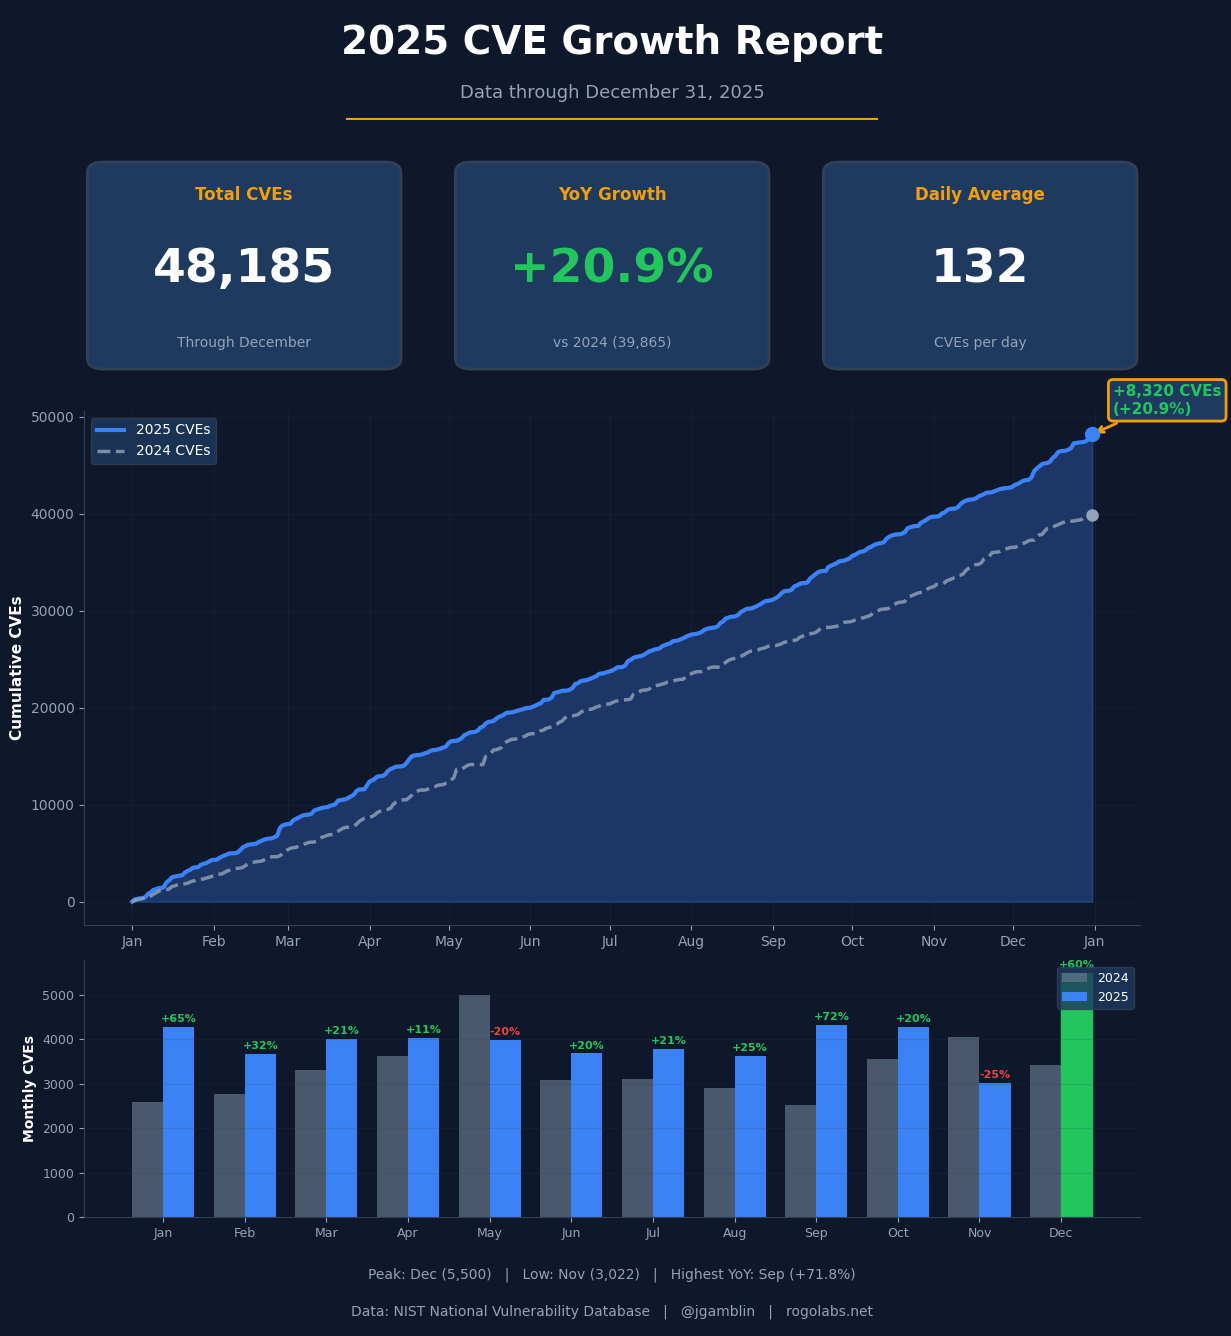

Light theme saved: CVE_Executive_Summary_2025_light.png


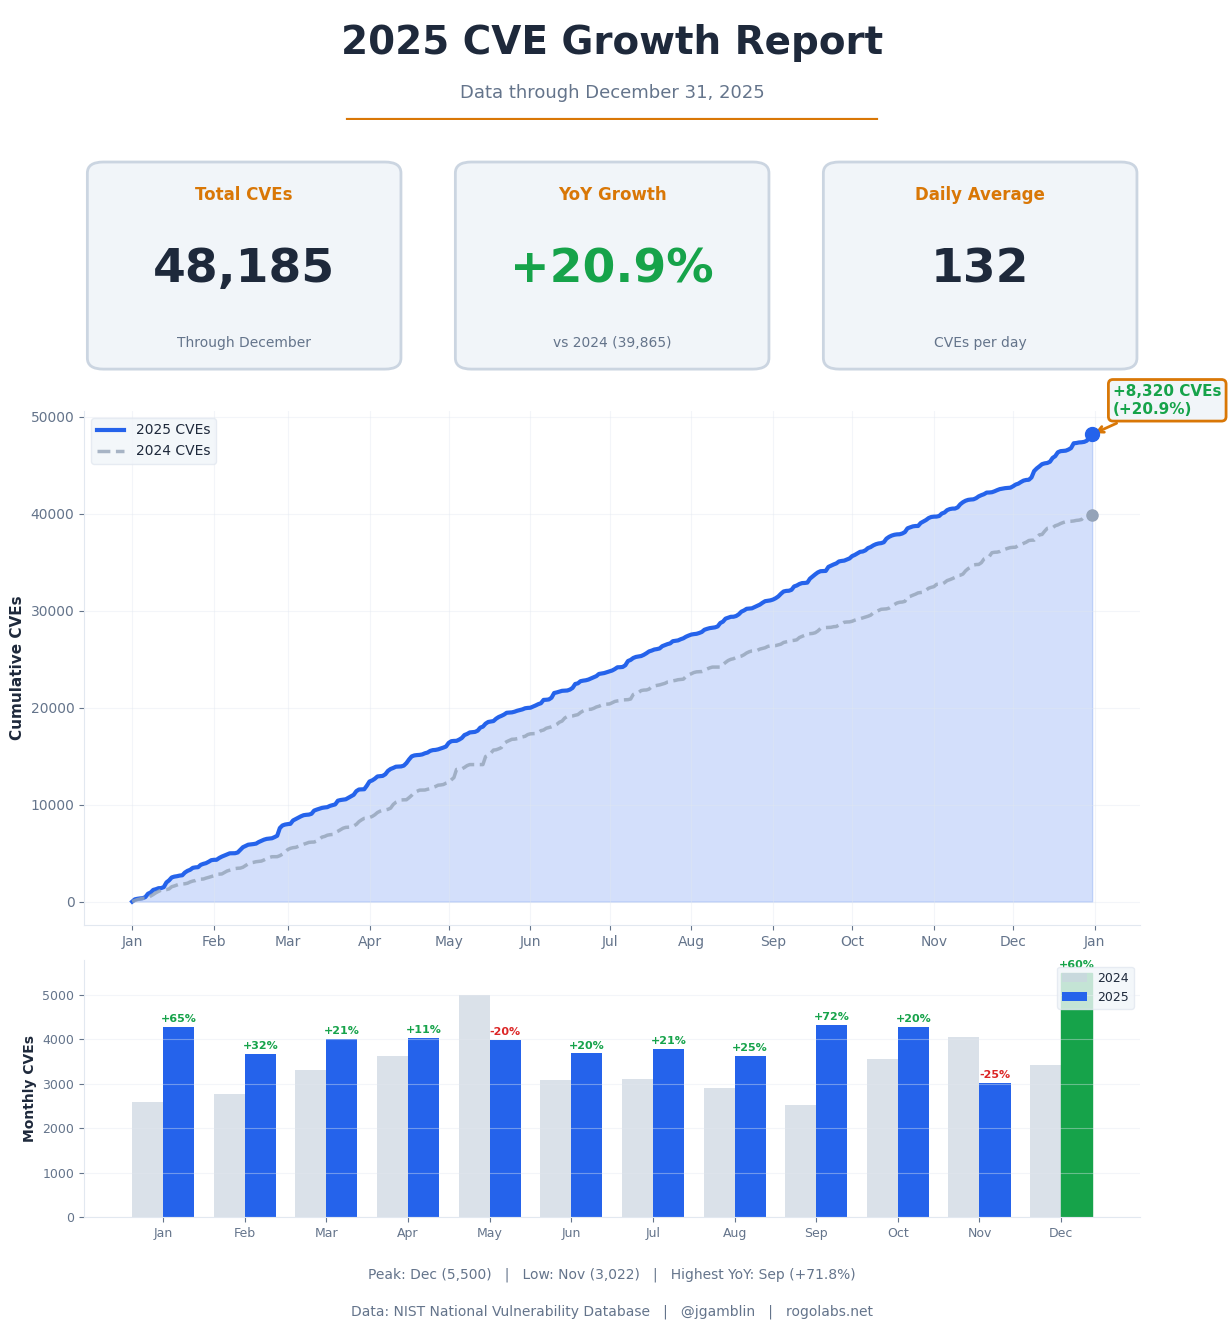

In [4]:
# Generate infographics (Dark & Light themes)
def create_infographic(theme='dark'):
    fig = plt.figure(figsize=(12, 14))
    
    # Theme colors
    if theme == 'dark':
        bg_color, card_color, accent_color = '#0f172a', '#1e3a5f', '#f59e0b'
        text_color, muted_color, grid_color = 'white', '#94a3b8', '#334155'
        line_2025, line_2024, bar_2024, bar_2025 = '#3b82f6', '#94a3b8', '#64748b', '#3b82f6'
    else:
        bg_color, card_color, accent_color = '#ffffff', '#f1f5f9', '#d97706'
        text_color, muted_color, grid_color = '#1e293b', '#64748b', '#e2e8f0'
        line_2025, line_2024, bar_2024, bar_2025 = '#2563eb', '#94a3b8', '#cbd5e1', '#2563eb'
    
    positive_color = '#22c55e' if theme == 'dark' else '#16a34a'
    negative_color = '#ef4444' if theme == 'dark' else '#dc2626'
    
    fig.patch.set_facecolor(bg_color)
    gs = fig.add_gridspec(5, 3, height_ratios=[0.6, 1.2, 2.8, 1.4, 0.4], hspace=0.15, wspace=0.15,
                          left=0.06, right=0.94, top=0.96, bottom=0.02)
    
    # Header
    ax_header = fig.add_subplot(gs[0, :])
    ax_header.set_facecolor(bg_color)
    ax_header.axis('off')
    ax_header.text(0.5, 0.7, f'{current_year} CVE Growth Report', fontsize=28, fontweight='bold', 
                   color=text_color, ha='center', va='center', transform=ax_header.transAxes)
    ax_header.text(0.5, 0.25, f'Data through {report_date}', fontsize=13, 
                   color=muted_color, ha='center', va='center', transform=ax_header.transAxes)
    ax_header.axhline(y=0.0, xmin=0.25, xmax=0.75, color=accent_color, linewidth=3)
    
    # Key metrics
    metrics = [
        ('Total CVEs', f'{graph_total_cves_2025:,}', f'Through {current_month_name}', None),
        ('YoY Growth', f'{graph_yoy_growth:+.1f}%', f'vs 2024 ({graph_total_cves_2024:,})', graph_yoy_growth >= 0),
        ('Daily Average', f'{overall_avg:.0f}', 'CVEs per day', None),
    ]
    
    for idx, (title, value, subtitle, is_positive) in enumerate(metrics):
        ax = fig.add_subplot(gs[1, idx])
        ax.set_facecolor(card_color)
        ax.axis('off')
        border_color = grid_color if theme == 'dark' else '#cbd5e1'
        rect = FancyBboxPatch((0.03, 0.05), 0.94, 0.90, boxstyle="round,pad=0.02,rounding_size=0.05",
                              facecolor=card_color, edgecolor=border_color, linewidth=2, transform=ax.transAxes)
        ax.add_patch(rect)
        ax.text(0.5, 0.82, title, fontsize=12, color=accent_color, ha='center', va='center',
                transform=ax.transAxes, fontweight='bold')
        value_color = text_color
        if is_positive is not None:
            value_color = positive_color if is_positive else negative_color
        ax.text(0.5, 0.48, value, fontsize=34, color=value_color, ha='center', va='center',
                transform=ax.transAxes, fontweight='bold')
        ax.text(0.5, 0.15, subtitle, fontsize=10, color=muted_color, ha='center', va='center',
                transform=ax.transAxes)
    
    # Main chart
    ax_main = fig.add_subplot(gs[2, :])
    ax_main.set_facecolor(bg_color)
    ax_main.fill_between(current_dates, current_cumulative, alpha=0.2 if theme == 'light' else 0.3, color=line_2025)
    ax_main.plot(current_dates, current_cumulative, linewidth=3, color=line_2025, label=f'{current_year} CVEs')
    ax_main.plot(normalized_previous_dates, previous_cumulative, linewidth=2.5, color=line_2024, 
                 linestyle='--', label=f'{previous_year} CVEs', alpha=0.8)
    ax_main.plot(current_dates[-1], current_cumulative.iloc[-1], 'o', color=line_2025, markersize=10, zorder=5)
    ax_main.plot(normalized_previous_dates[-1], previous_cumulative.iloc[-1], 'o', color=line_2024, markersize=8, zorder=5)
    
    growth_diff = graph_total_cves_2025 - graph_total_cves_2024
    ax_main.annotate(f'+{growth_diff:,} CVEs\n({graph_yoy_growth:+.1f}%)', 
                    xy=(current_dates[-1], current_cumulative.iloc[-1]),
                    xytext=(15, 15), textcoords='offset points',
                    fontsize=11, fontweight='bold', color=positive_color if graph_yoy_growth >= 0 else negative_color,
                    bbox=dict(boxstyle='round,pad=0.3', facecolor=card_color, edgecolor=accent_color, linewidth=2),
                    arrowprops=dict(arrowstyle='->', color=accent_color, lw=2))
    
    ax_main.set_ylabel('Cumulative CVEs', fontsize=11, color=text_color, fontweight='bold')
    ax_main.tick_params(colors=muted_color, labelsize=10)
    ax_main.xaxis.set_major_locator(mdates.MonthLocator())
    ax_main.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax_main.grid(True, alpha=0.2 if theme == 'dark' else 0.4, color=grid_color)
    ax_main.spines['bottom'].set_color(grid_color)
    ax_main.spines['left'].set_color(grid_color)
    ax_main.spines['top'].set_visible(False)
    ax_main.spines['right'].set_visible(False)
    ax_main.legend(loc='upper left', fontsize=10, frameon=True, facecolor=card_color, 
                   edgecolor=grid_color, labelcolor=text_color)
    
    # Monthly bar chart
    ax_monthly = fig.add_subplot(gs[3, :])
    ax_monthly.set_facecolor(bg_color)
    x = np.arange(months_to_show)
    width = 0.38
    bars_2024 = ax_monthly.bar(x - width/2, monthly_df[2024].values[:months_to_show], width, 
                               label='2024', color=bar_2024, alpha=0.7)
    bars_2025 = ax_monthly.bar(x + width/2, monthly_df[2025].values[:months_to_show], width, 
                               label='2025', color=bar_2025)
    bars_2025[current_month_num - 1].set_color(negative_color if yoy_change_month < 0 else positive_color)
    
    for i, (bar24, bar25) in enumerate(zip(bars_2024, bars_2025)):
        yoy_val = yoy_by_month[i]
        color = positive_color if yoy_val >= 0 else negative_color
        ax_monthly.annotate(f'{yoy_val:+.0f}%', 
                           xy=(bar25.get_x() + bar25.get_width()/2, bar25.get_height()),
                           xytext=(0, 2), textcoords='offset points',
                           ha='center', va='bottom', fontsize=8, color=color, fontweight='bold')
    
    ax_monthly.set_xticks(x)
    ax_monthly.set_xticklabels(months_short[:months_to_show], color=muted_color, fontsize=10)
    ax_monthly.tick_params(colors=muted_color, labelsize=9)
    ax_monthly.set_ylabel('Monthly CVEs', fontsize=10, color=text_color, fontweight='bold')
    ax_monthly.grid(axis='y', alpha=0.2 if theme == 'dark' else 0.4, color=grid_color)
    ax_monthly.spines['bottom'].set_color(grid_color)
    ax_monthly.spines['left'].set_color(grid_color)
    ax_monthly.spines['top'].set_visible(False)
    ax_monthly.spines['right'].set_visible(False)
    ax_monthly.legend(loc='upper right', fontsize=9, frameon=True, facecolor=card_color, 
                      edgecolor=grid_color, labelcolor=text_color)
    
    # Footer
    ax_footer = fig.add_subplot(gs[4, :])
    ax_footer.set_facecolor(bg_color)
    ax_footer.axis('off')
    insights = f"Peak: {best_month_2025} ({int(best_month_count):,})   |   Low: {worst_month_2025} ({int(worst_month_count):,})   |   Highest YoY: {max_yoy_month} ({max_yoy_value:+.1f}%)"
    ax_footer.text(0.5, 0.7, insights, fontsize=10, color=muted_color, ha='center', va='center',
                   transform=ax_footer.transAxes)
    ax_footer.text(0.5, 0.2, 'Data: NIST National Vulnerability Database   |   @jgamblin   |   rogolabs.net', 
                   fontsize=10, color=muted_color, ha='center', va='center', transform=ax_footer.transAxes)
    
    return fig

# Generate both versions
fig_dark = create_infographic('dark')
fig_dark.savefig(f'CVE_Executive_Summary_{current_year}_dark.png', dpi=300, bbox_inches='tight', facecolor='#0f172a')
print(f"Dark theme saved: CVE_Executive_Summary_{current_year}_dark.png")
plt.show()

fig_light = create_infographic('light')
fig_light.savefig(f'CVE_Executive_Summary_{current_year}_light.png', dpi=300, bbox_inches='tight', facecolor='white')
print(f"Light theme saved: CVE_Executive_Summary_{current_year}_light.png")
plt.show()

In [5]:
# Generate social media post text
linkedin_post = f"""🔐 {current_year} CVE Growth Report - {current_month_name} Update

The vulnerability landscape continues to evolve. Here's what the data shows through {current_month_name} {current_year}:

📊 Year-to-Date Highlights:
• {graph_total_cves_2025:,} CVEs published ({graph_yoy_growth:+.1f}% vs 2024)
• {overall_avg:.0f} new vulnerabilities per day on average
• {graph_total_cves_2025 - graph_total_cves_2024:+,} more CVEs than same period last year

📈 Monthly Trends:
• Peak month: {best_month_2025} with {int(best_month_count):,} CVEs
• {current_month_name} saw {int(specific_month_data[2025]):,} CVEs ({yoy_change_month:+.1f}% YoY)
• Highest YoY growth: {max_yoy_month} at {max_yoy_value:+.1f}%

🎯 Key Takeaway:
{"The vulnerability disclosure rate continues to accelerate, highlighting the critical importance of robust vulnerability management programs." if graph_yoy_growth > 0 else "While growth has moderated, the sheer volume of CVEs demands continuous vigilance in vulnerability management."}

Data source: NIST National Vulnerability Database
#cybersecurity #vulnerabilitymanagement #infosec #CVE #securityresearch

---
@jgamblin | rogolabs.net
"""

twitter_post = f"""🔐 {current_year} CVE Update ({current_month_name})

📊 {graph_total_cves_2025:,} CVEs YTD ({graph_yoy_growth:+.1f}% vs 2024)
📈 {overall_avg:.0f} CVEs/day average
{"📉" if yoy_change_month < 0 else "📈"} {current_month_name}: {int(specific_month_data[2025]):,} CVEs ({yoy_change_month:+.1f}% YoY)

Source: NVD | @jgamblin | rogolabs.net
#cybersecurity #CVE #infosec"""

print("=" * 60)
print("LINKEDIN POST:")
print("=" * 60)
print(linkedin_post)

print("\n" + "=" * 60)
print("TWITTER/X POST:")
print("=" * 60)
print(twitter_post)

LINKEDIN POST:
🔐 2025 CVE Growth Report - December Update

The vulnerability landscape continues to evolve. Here's what the data shows through December 2025:

📊 Year-to-Date Highlights:
• 48,185 CVEs published (+20.9% vs 2024)
• 132 new vulnerabilities per day on average
• +8,320 more CVEs than same period last year

📈 Monthly Trends:
• Peak month: Dec with 5,500 CVEs
• December saw 5,500 CVEs (+60.3% YoY)
• Highest YoY growth: Sep at +71.8%

🎯 Key Takeaway:
The vulnerability disclosure rate continues to accelerate, highlighting the critical importance of robust vulnerability management programs.

Data source: NIST National Vulnerability Database
#cybersecurity #vulnerabilitymanagement #infosec #CVE #securityresearch

---
@jgamblin | rogolabs.net


TWITTER/X POST:
🔐 2025 CVE Update (December)

📊 48,185 CVEs YTD (+20.9% vs 2024)
📈 132 CVEs/day average
📈 December: 5,500 CVEs (+60.3% YoY)

Source: NVD | @jgamblin | rogolabs.net
#cybersecurity #CVE #infosec
